In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

# Question 1:
## Anomaly in number of web pages accessed by user. Could a bot be copying the curriculum?



### Columns included:
- Unnamed: 0
- date
- time
- path
- user_id
- cohort_id
- ip'
- id
- name
- slack
- start_date
- end_date
- created_at
- updated_at
- deleted_at
- program_id

### Only need:
- date
- path
- user_id
- cohort_id
- ip

In [9]:
# Columns names needed for exploration
colnames = ['date','path','user_id','cohort_id','ip']

# pull create dataframe from txt
df = pd.read_csv('anonymized-curriculum-access.txt', sep="\s", header=None, names=colnames, usecols=[0, 2, 3, 4, 5])

# new df with only needed columns
df = df[colnames]

df.head()

,date,path,user_id,cohort_id,ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [10]:
# convert date col into datetime datatype
df.date = pd.to_datetime(df.date)

# set date as index
df = df.set_index(df.date)

# create a series called pages that counts # of logs per day
pages = df['path'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

<AxesSubplot:xlabel='date'>

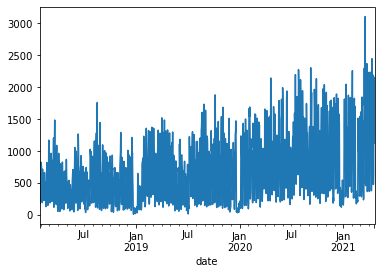

In [11]:
# visualize series as histogram
pages.plot()

### Normally Data would be split here, that is not necessary at the moment since we are using a statistics based approach and are not at risk of oversampling 

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [12]:
# set span as number of days
span = 30

# midband is the Exponential Moving Average on pages
midband = pages.ewm(span=span).mean()

# compute Exponential Moving Standard Deviation on pages
std = pages.ewm(span=span).std()

In [13]:
midband.head(2)

date
2018-01-26    572.0
2018-01-27    395.3
Freq: D, Name: path, dtype: float64

In [14]:
std.head(2)

date
2018-01-26           NaN
2018-01-27    241.830519
Freq: D, Name: path, dtype: float64

In [15]:
# establish number of standard deviations from EMA, k
k = 3

# create upper and lower band, ub and lb.
ub = midband + (std * k)
lb = midband - (std * k)

In [16]:
# concat pages, midband, ub, and lb as single df
bb_df = pd.concat([pages, midband, ub, lb], axis=1)

# Name columns of boiler band df
bb_df.columns = ['pages','midband','ub','lb']
bb_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


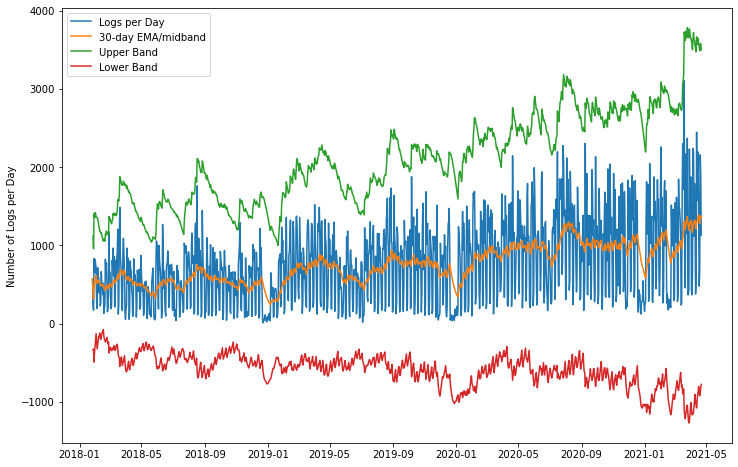

In [18]:
# creates subplot graph area 
fig, ax = plt.subplots(figsize=(12,8))

# 
ax.plot(bb_df.index, bb_df.pages, label='Logs per Day')

ax.plot(bb_df.index, bb_df.midband, label = '30-day EMA/midband')
ax.plot(bb_df.index, bb_df.ub, label = 'Upper Band')
ax.plot(bb_df.index, bb_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of Logs per Day')

plt.show()

## Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

- last = current measurement of pages


In [31]:
bb_df['pct_b'] = (bb_df.pages - bb_df.lb) / (bb_df.ub - bb_df.lb)

In [32]:
bb_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


## Creating Functions to do everything above 

In [5]:
def acquire(file_name, column_names):
    '''
    
    Description:
    ------------
    This function acquires a text file, 
    labels the columns as specifiied in the column_names list, and
    returns a pandas dataframe.
    
    Parameters:
    -----------
    file_name: str
        String containing the location and file name of desired file
    column_names: list
        List of the column names 
    
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''
    
    Description:
    ------------
    This function takes in a dataframe, 
    limits it to a specific user, 
    converts date column to datetime datatype and sets it as index, and
    creates and returns a series containing total number of logs the user accessed per day,
    
    Parameters:
    -----------
    df: pandas dataframe
        Dataframe containing date column, user_id, and endpoint columns
    user: int
        The specific user to be highlighted
        
    '''
    # creates df isolating single user
    df = df[df.user_id == user]
    
    # converts df.date into datetime and sets it as index
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    
    # creates a series that has date index and total number of logs
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    
    Description:
    ------------
    This function takes in a series, a span, a weight, and a user.
    Then creates bollinger bands, midband, upper band, and lower band, 
    then calculates the percent bandwidth of each day, finally
    returns a dataframe containing the information specific to a single user.
    
    Parameters:
    -----------
    pages: series
        Series with a datetime index
    span: int
        Span is the number of days to be used in exponential weighted functions
    weight: int
        Weight is a value, k, that is to be multiplied to the standard deviation, and 
        is used to create the upper and lower bands.
    user: int
        The specific user to be highlighted
    
    
    '''
    # creates midband
    midband = pages.ewm(span=span).mean()
    
    # establishes the standard deviation
    stdev = pages.ewm(span=span).std()
    
    # creates upper and lower bands 
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # combines upper and lower bands as a dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # combines the pages and midband to the bb_df, and renames the columns
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    
    # creates the column that holds the percent bandwidth
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    
    # adds the user column
    my_df['user_id'] = user
    
    # return dataframe
    return my_df

def plt_bands(my_df, user):
    '''
    
    Description:
    ------------
    This function plots a bollinger bands graph of a specific user.
    
    Parameters:
    -----------
    my_df: dataframe
        A dataframe containing the columns: 'pages', 'midband', 'ub', 'lb'
    user: int
        The specific user to be highlighted
    
    '''
    # creates sub plots and sets figure size
    fig, ax = plt.subplots(figsize=(12,8))
    
    # x = time, y = number of logs
    ax.plot(my_df.index, my_df.pages, label='Number of Logs, User: '+str(user))
    
    # x = time, y = midband
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    
    # x = time, y = upper band
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    
    # x = time, y = lower band
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    
    # creates the legend
    ax.legend(loc='best')
    
    # creates the y axis label
    ax.set_ylabel('Number of Logs')
    
    # displays all open figures
    plt.show()
    
def find_anomalies(df, user, span, weight):
    '''
    Description:
    ------------
    This function combines, prep, compute_pct_b, and plt_bands functions, and 
    returns a dataframe of instances where the number of logs 
    is greater than the upper band.
    
    Parameters:
    -----------
    df: dataframe
        Dataframe containing date column, user_id, and endpoint columns
    user: int
        The specific user to be highlighted
    span: int
        Span is the number of days to be used in exponential weighted functions
    weight: int
        Weight is a value, k, that is to be multiplied to the standard deviation, and 
        is used to create the upper and lower bands.
    
    '''
    # calls the prep function, returns the pages series
    pages = prep(df, user)
    
    # calls the compute_pct_b function, returns a dataframe
    my_df = compute_pct_b(pages, span, weight, user)
    
    # calls plt_bands function, plots a bollinger bands graph
#     plt_bands(my_df, user)   # <--- Silenced due to time
    
    # returns a dataframe of instances greater than the upper band
    return my_df[my_df.pct_b>1]

#### Test Acquire

In [58]:
file_name = "anonymized-curriculum-access.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


#### Test prep

In [59]:
pages = prep(df, user=844)
pages.head()

date
2020-12-08    20
2020-12-09    11
2020-12-10    52
2020-12-11     0
2020-12-12     1
Freq: D, Name: endpoint, dtype: int64

#### Test compute_pct_b

In [60]:
span = 30
weight = 3
user = 844

bb_df = compute_pct_b(pages, span, weight, user)
bb_df.head()

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-12-08,20,20.000000,NaN,NaN,NaN,844
2020-12-09,11,15.350000,34.441883,-3.741883,0.386077,844
2020-12-10,52,28.389856,94.258081,-37.478370,0.679223,844
2020-12-11,0,20.567416,89.336548,-48.201717,0.350460,844
2020-12-12,1,16.115355,80.805963,-48.575253,0.383172,844


#### Test plt_bands

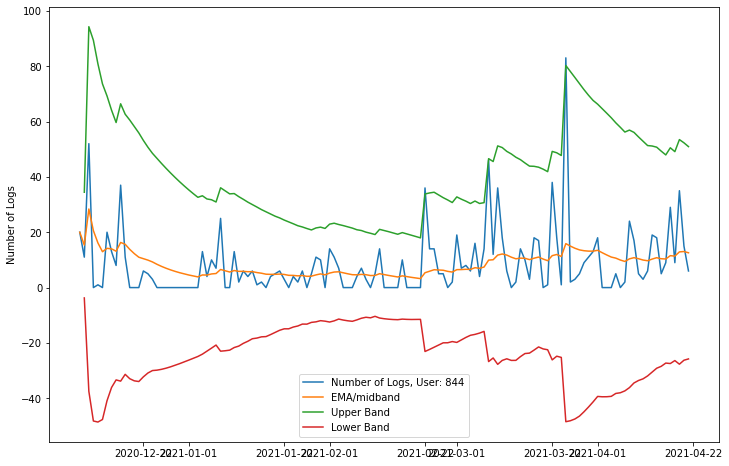

In [61]:
plt_bands(bb_df, user)

#### Test find_anomalies

In [62]:
find_anomalies(df, user, span, weight)

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-02-22,36,5.362496,33.812805,-23.087812,1.038439,844
2021-03-25,83,15.881116,80.221041,-48.458809,1.021596,844


## Run find_anomalies in a loop on all users 

In [309]:
span=30
k=3.743883901333836

In [310]:
anomalies_df = pd.DataFrame()

In [311]:
for user in list(df.user_id.unique()):
    user_df = find_anomalies(df, user, span=span, weight=k)
    anomalies_df = pd.concat([anomalies_df, user_df], axis = 0)

In [313]:
anomalies_df.sort_values(by='pct_b', ascending=False)

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-03-28,15,0.967742,15.0,-13.064516,1.0,13
